In [1]:
import baostock as bs
import pandas as pd
import mplfinance as mpf
import numpy as np

# 登录baostock系统
lg = bs.login()

# 获取上证指数的历史K线数据，同时过滤非交易日
symbol = "sh.000001"  # 上证指数代码
start_date = '2024-01-01'
end_date = '2025-01-01'
frequency = 'd'  # 日线数据
fields = "date,open,high,low,close,volume"

# 获取股票数据
rs = bs.query_history_k_data(symbol,
                              "date,open,high,low,close,volume",
                              start_date=start_date,
                              end_date=end_date,
                              frequency="d",
                              adjustflag="3")  # adjustflag="3"表示不复权
data = rs.get_data()

# 将数据重新格式化以适应mplfinance的要求
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# 转换为float
data[['open', 'high', 'low', 'close', 'volume']] = data[['open', 'high', 'low', 'close', 'volume']].astype(float)

# 登出baostock系统
bs.logout()

login success!
logout success!


In [2]:
# 寻找最低低点
min_low_index = data['low'].idxmin()
min_low = data['low'].min()

# 输出对应的内容
min_low_index,min_low


(Timestamp('2024-02-05 00:00:00'), 2635.0897)

In [3]:
data.loc[:min_low_index]

,open,high,low,close,volume
date,,,,,
2024-01-02,2972.7750,2976.2682,2962.2762,2962.2762,3.041418e+10
2024-01-03,2957.1117,2971.2834,2953.2901,2967.2472,2.854559e+10
2024-01-04,2965.5087,2966.6828,2936.6347,2954.3486,2.649809e+10
2024-01-05,2949.8221,2967.9677,2916.7206,2929.1833,3.010402e+10
2024-01-08,2923.4570,2924.4559,2887.5379,2887.5379,2.702751e+10
2024-01-09,2887.1095,2900.7266,2878.4123,2893.2513,2.629560e+10
2024-01-10,2886.9807,2903.1621,2870.4155,2877.7023,2.440465e+10
2024-01-11,2873.7982,2896.1788,2867.7223,2886.6502,2.670508e+10
2024-01-12,2880.0399,2904.1743,2878.8752,2881.9769,2.616029e+10


In [4]:
# 寻找最高高点前的低点，确保趋势线不穿越其他价格

# 找到最高点前的某一个低点
max_index = data['high'].idxmax()
candidate_low_index = min_low_index

# 计算最低低点和最高点之间的直线的斜率和截距
slope = (data['low'][max_index] - data['low'][min_low_index]) / (max_index - min_low_index).days 
intercept = data['low'][min_low_index]
slope, intercept


(19.160172222222222, 2635.0897)

In [5]:
# 找到 min_low_index 在索引中的位置
min_low_index_pos = data.index.get_loc(min_low_index)

# 迭代
for i in range(min_low_index_pos + 1, data.index.get_loc(max_index)):
    # 当前低点
    current_low = data['low'].iloc[i]

    # 判断连接最低低点和当前低点的直线是否与其他K线数据相交
    line_y = slope * i + intercept
    if any(data.iloc[min_low_index_pos:i, data.columns.get_loc('low')] < line_y) or any(data.iloc[min_low_index_pos:i, data.columns.get_loc('high')] > line_y):
        continue  # 如果相交，继续遍历下一个低点

    # 更新候选低点为当前低点
    candidate_low_index = data.index[i]

    # 重新计算斜率和截距
    slope = (data['low'][max_index] - data['low'][candidate_low_index]) / (max_index - candidate_low_index).days
    intercept = data['low'][candidate_low_index] - slope * (candidate_low_index - min_low_index).days

# 打印找到的最高点前的某一个低点的索引
print("Index of low before max:", candidate_low_index)
print("slope : ", slope)
print("intercept : ", intercept)


Index of low before max: 2024-02-05 00:00:00
slope :  19.160172222222222
intercept :  2635.0897


In [6]:
point1 = min_low_index
point2 = candidate_low_index
# 创建连接线的数据
line_data = pd.DataFrame({
    'date': [point1, point2],
    'line': [data['low'].loc[point1], data['low'].loc[point2]]
})

ValueError: x and y must have same first dimension, but have shapes (33,) and (2,)

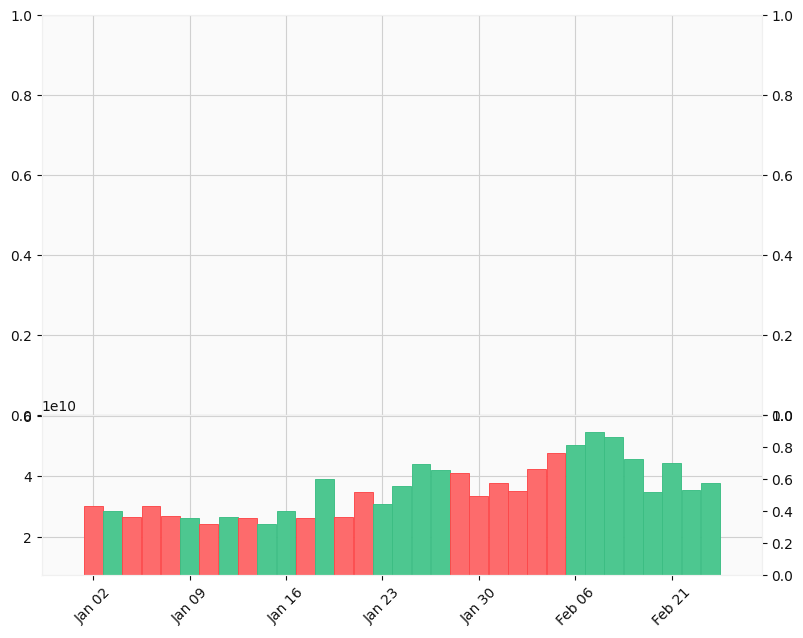

In [7]:

# 绘制K线图和连接线
mpf.plot(data, type='candle', style='yahoo', volume=True, addplot=[
    mpf.make_addplot(line_data['line'], color='orange', secondary_y=False, linestyle='dashed')
], figsize=(10, 8))